# Introduction

The objective of the TensorSat project is to build an SMT solver based on techniques analogous to [hyper-optimized tensor network contraction](https://arxiv.org/abs/2002.01935) techniques used in quantum simulation.

To achieve this, TensorSat replaces predicates and formulae with categorical diagrams, taking their idealised semantics into the [hypergraph category](https://arxiv.org/abs/1806.08304) of sets and relations.
Functions and predicates are replaced by general relations, with synthetic composition rules used to contract diagrams and compute answers to satisfiability problems.

A **diagram** is formed by **wiring** together **boxes** from one or more **languages**, compatibly with the **types** specified by the boxes' **ports**.
Every language defines a parametrised family of boxes, together with computational semantics in the form of contractions for arbitrary wirings of boxes of that class.
Such contractions can be reduced to three basic cases:

- `spider`: converts a wire &mdash; connecting any positive number of ports &mdash; into a box in the language (as long as the wire type is one in the language).
- `contract2`: contracts arbitrary wirings of any two boxes in the language.
- `rewire`: reorders, duplicates and removes ports for any box in the language.

Inheritance can be used to relate multiple boxclasses and define multiple versions of the `contract2` boxclass method, which enables hybrid contraction of boxes from different concrete boxclasses. Every language defines a root boxclass, with a `contract2` implementation which works for all boxes in the language. 

Additionally, a flexible boxclass cast mechanism is planned, see this [GitHub tracking issue](https://github.com/hashberg-io/tensorsat/issues/8).

### A Categorical Aside

In categorical terms, a language corresponds to the hypergraph category freely generated by a parametrised family of types (object generators) and boxes (morphism generators).
Boxes are normalised to have the tensor unit as their domain: their signature takes the form $I \rightarrow X_0 \otimes ... \otimes X_{n-1}$, the indices $\lbrace 0, ..., n-1 \rbrace$ are the ports of the box, and we say that the generator $X_j$ is the type of port $j$.

A diagram involving boxes from one or more languages is a diagram in hypergraph category freely-generated by the union of their types and boxes.
The wiring of boxes in a diagram is a normalised representation of the diagram's compositional structure modulo the axioms of hypergraph categories (cf. [arXiv:1512.01602](https://arxiv.org/abs/1512.01602)).

Mathematically, languages have semantics in the hypergraph category Rel of sets and finitary relations.
Computationally, the semantics for each individual language are captured by providing an implementation for the `spider`, `rewire` and `contract2` rewrites which is sound for the Rel semantics (i.e. one such that the rewrite corresponds to an equation in Rel).

Formally, the rewrites equations turning a diagram in the language (two boxes, one box, and no boxes, respectively) into a single box in the same language.
Taken together, they give rise to a strongly confluent rewriting system which can be used to contract arbitrary diagrams in the language into a single box of the same language, providing computational semantics.

Types and boxes for multiple languages are allowed to overlap, and it is required that the Rel semantics be compatible over such overlaps; that is, multiple languages assign the same set semantics to the same type, and the same relation semantics to the same box, whenever they have types and/or boxes in common.
Because of this, contraction in diagrams involving multiple languages does not necessarily result in a confluent rewriting system.

## Languages


Types and boxes are the basic building blocks of a diagrammatic language.
Diagrams are formed by wiring boxes (or sub-diagrams) together, relying on matching types to determine which wirings are allowed and which ones are not.

Every language defines boxes and/or types, by means of concrete subclasses of the abstract base classes `Box` and `Type`, respectively.

```py
from tensorsat.diagrams import Box, Type
```

Languages are implemented as sub-modules of the `tensorsat.lang` module.

## The language `fin_rel`

The language `fin_rel` contains:

- **Types:** Finite enumerated sets (in the form $\lbrace 0,...,n-1 \rbrace$ for size $n \geq 1$).
- **Boxes:** Finitary relations between finite enumerated sets, parametrised by Boolean tensors.

Specifically, a relation $R \subseteq \prod\limits_{k=0}^{m-1} {0,...,n_k}$ can be densely represented by its indicator function:

$$
1_R: \prod_{k=0}^{m-1} {0,...,n_k} \rightarrow \lbrace 0, 1 \rbrace
$$

Embedding $\lbrace 0, 1 \rbrace$ with the structure of the Boolean semiring, such indicator functions take the form of Boolean tensors.



- The types of `fin_rel` are instances of the class `FinSet`. They are finite, explicitly enumerated sets in the form $\lbrace 0,...,n-1 \rbrace$.
- The boxes of `fin_rel` are instances of the class `FinRel`. They are finite relations between finite sets, explicitly present by dense Boolean tensors.



In [1]:
import numpy as np
from tensorsat.lang.fin_rel import FinSet, FinRel

Boxes in `fin_rel` are parametrised by Boolean tensors: these can be accessed via the `tensor` property of `FinRel` instances, in the form of NumPy UInt8 arrays.
As an example, consider the `and_` operator from the `bincirc` library.

In [2]:
from tensorsat.lib.bincirc import and_
and_.tensor

array([[[1, 0],
        [1, 0]],

       [[1, 0],
        [0, 1]]], dtype=uint8)

The `and_` gate is a ternary relation:

$$
\texttt{and\_} :=
\left\lbrace (a, b, a\&b) \middle| a, b \in \lbrace 0, 1 \rbrace \right\rbrace
\subset \lbrace 0, 1 \rbrace^3
$$

By our convention, input components are listed before output components.

For a relation $R \subseteq \prod\limits_{k=0}^{m-1} {0,...,n_k}$, the Boolean tensor has rank $m$ and shape $(n_0,...,n_{m-1})$.
For the `and_` gate, the rank is 3 and the shape is `(2, 2, 2)`.

In [3]:
print(f"{len(and_.tensor.shape) = }") # rank
print(f"{and_.tensor.shape = }") # shape
# (2, 2, 2)
#        ^ 1 output bit
#  ^^^^ 2 input bits

len(and_.tensor.shape) = 3
and_.tensor.shape = (2, 2, 2)


We can enumerate the set of tuples in a relation by iterating over all elements of the relation's domain, using them to index the Boolean tensor, and keeping those where the tensor has value 1. Later on, we'll see that the utility method `to_set` serves the same purpose.

In [4]:
print({
    point
    for point in np.ndindex(and_.tensor.shape)
    if and_.tensor[point]
})
# { (0 , 0 , 0), (0 , 1 , 0), (1 , 0 , 0), (1 , 1 , 1) }
#    0 & 0 = 0    0 & 1 = 0    1 & 0 = 0    1 & 1 = 1

{(1, 0, 0), (0, 0, 0), (1, 1, 1), (0, 1, 0)}


By flattening the input and output components, we can also obtain a more traditional representation of the gate as a Boolean matrix. According to our convention, where input components appear first, the resulting matrix acts naturally to the left on row Boolean vectors.
In this representation, the rows are the indicator functions for the output values of the gate on its 4 inputs.

In [5]:
and_.tensor.reshape(4, 2)
# [[1, 0], < indicator of 0 ∈ {0, 1}, the output on (0, 0)
#  [1, 0], < indicator of 0 ∈ {0, 1}, the output on (0, 1)
#  [1, 0], < indicator of 0 ∈ {0, 1}, the output on (1, 0)
#  [0, 1]] < indicator of 1 ∈ {0, 1}, the output on (1, 1)

array([[1, 0],
       [1, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

To obtain the more traditional presentation, acting to the right on column Boolean vectors, it suffices to take the transpose.
In this representations, the columns are the indicator functions for the output values instead.

In [6]:
and_.tensor.reshape(4, 2).T
# [[1, 1, 1, 0],
#  [0, 0, 0, 1]]
#            ^ indicator of 1 ∈ {0, 1}
#         ^ indicator of 0 ∈ {0, 1}
#      ^ indicator of 0 ∈ {0, 1}
#   ^ indicator of 0 ∈ {0, 1}

array([[1, 1, 1, 0],
       [0, 0, 0, 1]], dtype=uint8)

## Types

Types are used to signal compatibility of wiring between ports of boxes.

The constructors of concrete sub-classes of `Type` define the parametrisation for the types in the language. In the case of `FinSet`, explicitly enumerated sets are parametrised by a strictly positive integer size.

In [7]:
bit = FinSet(2)  # {0, 1}
trit = FinSet(3) # {0, 1, 2}

## Boxes

Boxes act as the atomic building blocks of diagrams.

The constructors of the concrete subclass(es) of `Box` define the parametrisatino of boxes in the language. In the case of `FinRel`, relations are parametrised by Boolean tensors, in the form of NumPy's `uint8` arrays with values in $\lbrace 0, 1 \rbrace$.

In [8]:
and_ = FinRel(np.array([
    [
        [
            1 if out == inl & inr else 0
            for out in [0, 1]
        ]
        for inr in [0, 1]
    ]
    for inl in [0, 1]
], dtype=np.uint8))
and_

<FinRel: 3 ports>

Because the raw parametrisation can be inconvenient, concrete subclasses of `Box` typically offer additional utility constructors, in the form of class methods. In the case of `FinRel`, examples include constructors from:

- explicit sets of tuples, via `FinRel.from_set`
- input-output mappings of functions, via `FinSet.from_mapping`
- implementations of functions, via `FinSet.from_callable`


In [9]:
assert and_ == FinRel.from_set((2,2,2), {
    #       input bits at start ^^^ ^ output bit at end
    (a, b, a&b)
    for a in [0, 1]
    for b in [0, 1]
})
assert and_ == FinRel.from_callable(
    (2, 2), # input shape (2 bits input)
    2,      # output shape (1 bit output), same as (2,)
    lambda a, b: a&b # function implementation
    #            ^^^ same as (a&b,)
)
assert and_ == FinRel.from_mapping((2,2), 2, {
    (a, b): a&b
    #       ^^^ same as (a&b,)
    for a in [0, 1]
    for b in [0, 1]
})

All boxes have a `shape`, which defines the number and type of ports for the box.

In [10]:
print(f"{and_.shape = }")

and_.shape = (FinSet(2), FinSet(2), FinSet(2))


Each concrete `Box` subclass defines additional properties exposing the data parametrising them. In the case of `FinRel`, the `tensor` property exposes the underlying Boolean tensor (as a readonly view).

In [11]:
and_.tensor

array([[[1, 0],
        [1, 0]],

       [[1, 0],
        [0, 1]]], dtype=uint8)

Concrete `Box` subclasses also define properties and methods relevant to the language's semantics, especially relating boxes to various kinds of data which can be passed to utility constructors of the boxclass.

In [12]:
# Inverse of FinRel.from_set:
print(f"{set(and_.to_set()) = }")
# {(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)}

# Inverse of FinRel.from_mapping:
input_ports = [0, 1]
print(f"{and_.to_mapping(input_ports) = }")
# {(0, 0): (0,), (0, 1): (0,), (1, 0): (0,), (1, 1): (1,)}

# Inverse of FinRel.from_callable:
and_func = and_.to_callable(input_ports)
print(f"{and_func = }")
# <function <lambda> at 0x000001C4F48B1D00>
input_sizes = tuple(and_.shape[i].size for i in input_ports)
for i0, i1 in np.ndindex(input_sizes):
    print(f"and_func({i0}, {i1}) = {and_func(i0, i1)}")

set(and_.to_set()) = {(1, 0, 0), (0, 0, 0), (1, 1, 1), (0, 1, 0)}
and_.to_mapping(input_ports) = {(0, 0): (0,), (0, 1): (0,), (1, 0): (0,), (1, 1): (1,)}
and_func = <function <lambda> at 0x0000022DCD7BF560>
and_func(0, 0) = (0,)
and_func(0, 1) = (0,)
and_func(1, 0) = (0,)
and_func(1, 1) = (1,)


## Libraries

Thematic collections of named types and boxes are made available as part of libraries, together with utility classes and functions. Libraries are implemented as sub-modules of the `tensorsat.lib` module.

For our subsequent examples, we will use types and boxes from the `bincirc` library, implementing binary circuits.

In [13]:
from tensorsat.lib.bincirc import (
    bit,     # bit type {0, 1}
    bits,    # bit shape constructor
    bit_0,   # bit constant value 0
    bit_1,   # bit constant value 1
    bit_unk, # unknown bit value, i.e. the set {0, 1}
    not_,    # unary NOT operator
    and_,    # binary AND operator
    or_,     # binary OR operator
    xor_,    # binary XOR operator
)

We will also use the `CNFInstance` utility class from the `sat` library, which can be used to construct SAT instances in CNF and generate related diagrams.

In [14]:
from tensorsat.lib.sat import CNFInstance
cnf = CNFInstance.random(3, 3, 6, rng=3)
cnf

<CNFInstance: 3 vars, 6 clauses, k=3>

Clauses are stored using DIMACS conventions, as signed non-zero integers:

- the sign of an integer indicates whether a literal is positive or negative.
- the absolute value of an integer is one plus the index of the variable in the literal.

Variables are zero-indexed, so the following formula is:

$$
\bigwedge
\begin{cases}
\neg x_2 \vee \neg x_0 \vee x_1\\
\neg x_2 \vee x_0 \vee x_1\\
x_0 \vee \neg x_1 \vee x_2\\
\neg x_1 \vee \neg x_0 \vee x_2\\
\neg x_0 \vee x_1 \vee x_2\\
\neg x_1 \vee x_0 \vee x_2
\end{cases}
$$

In [15]:
cnf.clauses

((-3, -1, 2), (-3, 1, 2), (1, 2, 3), (-2, -1, 3), (-1, 2, 3), (-2, 1, 3))

The `diagram` can be used to create diagrams representing the formula, with ports corresponding to the formula's variables.

In [16]:
cnf.diagram(mode="bintree")

<Diagram: 22 wires, 25 blocks, 3 ports>

## Simple Contraction

Concrete `Box` subclasses also implement language-specific composition logic, which is accessible via three methods:

- the class method `spider`, to generate a box for a spider wiring
- the method `rewire`, for port permutation, removal and duplication
- the class method `contract2`, for pairwise contraction of boxes

We look at each one in turn, below.

The `spider` class method can be used to generate a box in the given boxclass which corresponds to the simplest kind of wiring, that comprised of a single wire with any given number of ports.
This implements the first of the three elementary rewrite rules for the language.

In [17]:
FinRel.spider(bit, 3)

<FinRel: 3 ports>

As a derived method, `from_wiring` can be used to generate boxes for arbitrary wirings, as long as all the wires have types compatible with the desired boxclass.

The `rewire` method can be called on a box instance to produce another instance of the same boxclass &mdash; and, as a consequence, a box in the same language &mdash; where ports of the original box have been permuted, removed, or duplicated, as specified by the argument to the method. This implements the second of the three elementary rewrite rules for the language.

As an example of rewiring, below we swap the right input of an AND gate with its output, obtaining a new relation:

In [18]:
and_transp = and_.rewire([0, 2, 1])
print(f"{sorted(and_.to_set())       = }")
print(f"{sorted(and_transp.to_set()) = }")

sorted(and_.to_set())       = [(0, 0, 0), (0, 1, 0), (1, 0, 0), (1, 1, 1)]
sorted(and_transp.to_set()) = [(0, 0, 0), (0, 0, 1), (1, 0, 0), (1, 1, 1)]


As another example, we verify that the XOR gate is invariant under such permutations:

In [19]:
xor_.rewire([0, 2, 1]) == xor_

True

As an example with discarding, we verify that dropping the control output of a CNOT gate yields a XOR gate:

In [20]:
cnot = FinRel.from_callable(
    (2, 2), # input shape (2 bits input)
    (2, 2), # output shape (2 bits output)
    lambda a, b: (a, a^b)
) # port # 0  1   2   3
cnot.rewire([0, 1, 3]) == xor_
#            ^^^^^^^ port 2 is discarded

True

As an example with copying, we verify that copying the first output of a XOR gate and returning it as its first output yields a CNOT gate:

In [21]:
xor_.rewire([0, 1, 0, 2]) == cnot
#            a  b  a a^b

True

The `contract2` classmethod can be called on any concrete `Box` subclass — as well as some abstract subclasses — to compose two boxes of that boxclass according to the given wiring.
For `FinRel` boxes, this composition is performed explicitly by Boolean tensor contraction, but other boxclasses implement other composition rules.
The `contract2` classmethod implements the third and final of the three elementary rewrite rules for a language.

As a simple example of composition, we generate the relation corresponding to the CNOT binary function:

$$
(a, b) \mapsto (a, a \oplus b)
$$

In [22]:
cnot = FinRel.contract2(
    FinRel.spider(bit, 3),
    [0, 2, 4],
    xor_,
    [4, 1, 3],
    [0, 1, 2, 3]
)
assert cnot == FinRel.from_callable((2,2), (2,2), lambda a, b: (a, a^b))

As another simple example of composition, we generate the relation corresponding to the following binary function:

$$
(a, b, c) \mapsto a \wedge (b \vee c)
$$

In [23]:
func = FinRel.contract2(
    or_,
    [1, 2, 3],
    and_,
    [0, 3, 4]
)
assert func == FinRel.from_callable((2,2,2), 2, lambda a, b, c: a&(b|c))

Finally, we look at multiple pairwise ontractions.
This is merely for educational purposes: in practice, such examples should be contracted using `Contraction` instances, which implement various kinds of contraction strategies.

We generate the relation corresponding to the following binary function:

$$
(a, b, c) \mapsto (a \vee c) \wedge (b \vee c)
$$

The first contraction involves two `or_` gates, with input $c$ (at index 2) copied into both, resulting in the following intermediate function:

$$
(a, b, c) \mapsto (a \vee c, b \vee c)
$$

The second contraction connects the two outputs of the intermediate function above into the two inputs of an `and_` gate, reuslting in our desired function.


In [24]:
_func = FinRel.contract2(
    or_,
    [0, 2, 3],
    or_,
    [1, 2, 4],
    out_wires=[0, 1, 2, 3, 4]
    #   inputs ^^^^^^^  ^^^^ outputs
)
assert _func == FinRel.from_callable((2,2,2), (2,2), lambda a, b, c: ((a|c), (b|c)))
func = FinRel.contract2(
    _func,
    [0, 1, 2, 3, 4],
    and_,
    [3, 4, 5]
)
assert func == FinRel.from_callable((2,2,2), 2, lambda a, b, c: (a|c)&(b|c))

## Diagrams

Diagrams are the syntax used by TensorSat to describe functions, predicates and formulae.

The internal data of diagrams consists of two parts:

- a `wiring`, describing the internal connectivity structure of the diagram;
- an assignment of boxes and/or sub-diagrams to (some of) the slots in the wiring.

As our first example, we look at the `full_adder` diagram from the `bincirc` library.

In [25]:
from tensorsat.lib.bincirc import half_adder, full_adder
full_adder

<Diagram: 8 wires, 5 blocks, 5 ports, from recipe 'full_adder'>

We we can use the `draw_diagram` function from the `tensorsat.viz` module (which contains visualization utilities) to graphically present the diagram:

- The diagram has 5 ports:
    - Ports 0, 1, and 2, on the left, are input ports;
    - Ports 3 and 4, on the right, are output ports.
- The diagram has 7 wires:
    - Wires 0, 1, and 2 are connected to the input ports;
    - Wires 3, 4, and 5 are internal;
    - Wires 6 and 7 are connected to the output ports;
- The diagram has 5 blocks, each filled with a box.

**Note:** In the nomenclature of hypergraph-categorical diagrams, **wire** is used to denote structural nodes which connect any number of ports: They can connect 2 ports (e.g. wires 2, 4, 6, and 7), as would be the case for ordinary wires, but can also connect multiple ports (e.g. wires 0, 1, 3, and 5) or a single port (in which case we say that the port is "discarded"). From the underlying perspective of symmetric monoidal categories, every object of a hypergraph category is equipped with a special commutative Frobenius algebra (SCFA), and wires are morphisms from the SCFA of the common type which they connect; from the perspective of hypergraph categories, on the other hand, wires are structural.

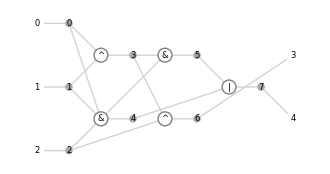

In [26]:
from tensorsat.viz import draw_diagram
from tensorsat.lib.bincirc import binop_labels # labels for binary operators

draw_diagram(
    full_adder,
    node_label={"box": binop_labels, "wire": str},
    layout="circuit",
    simplify_wires=False,
    figsize=(4, 2),
)

The connectivity structure for the boxes in the diagram is captured by its `wiring`, a data structure encoding the following:

- `wire_types`: the assignment of a type to each wire (here stored as a `Shape`);
- `slot_wires_list`: for each slot (here, each box), a sequence assigning a wire to each port;
- `out_wires`: a sequence assigning a wire to each (outer) port for the diagram.

For example, the first entry of `slot_wires_list` is `(0, 1, 3)`, indicating that the `xor_` box at the top left (marked `^`) has its three ports connected to the wires 0, 1 and 3.
The (outer) ports of the diagram are connected to wires 0, 1, and 2 (on the left), and to wires 6 and 7 (on the right).

In [27]:
print(f"{full_adder.wiring = }")
print(f"{full_adder.wiring.wire_types = }")
print(f"{full_adder.wiring.slot_wires_list = }")
print(f"{full_adder.wiring.out_wires = }")

full_adder.wiring = <Wiring: 8 wires, 5 slots, 5 out ports>
full_adder.wiring.wire_types = (FinSet(2), FinSet(2), FinSet(2), FinSet(2), FinSet(2), FinSet(2), FinSet(2), FinSet(2))
full_adder.wiring.slot_wires_list = ((0, 1, 3), (0, 1, 4), (3, 2, 5), (3, 2, 6), (4, 5, 7))
full_adder.wiring.out_wires = (0, 1, 2, 6, 7)


The `"circuit"` layout use above is useful for small diagrams, but makes it harder to appreciate the structure of larger diagrams.
For larger examples, we generally prefer the default [`"kamada_kawai"` layout](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html), which uses [force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing).
We also prefer the default `simplify_wires=True` value, which replaces wire nodes with simple edges wherever possible.

The result is an unordered, network-like presentation, which better reflects the unordered nature of tensor contractions in the hypergraph category of sets and relations.

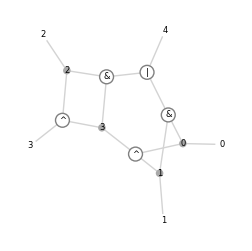

In [28]:
draw_diagram(
    full_adder,
    node_label={"box": binop_labels, "wire": str},
    figsize=(3, 3),
)

Diagrams are an immutable data structure, and can be instantiated by providing a wiring and an assignment of blocks (boxes, or other diagrams) for (some or all of) the slots of the wiring.

In [29]:
from tensorsat.diagrams import Diagram, Wiring

# Create wiring by specifying wire types and port-wire assignment (slots and outer):
wiring = Wiring(
    wire_types=bits(8),
    slot_wires_list=[(0, 1, 3), (0, 1, 4), (3, 2, 5), (3, 2, 6), (4, 5, 7)],
    out_wires=[0, 1, 2, 6, 7]
)
assert wiring == full_adder.wiring

# Create diagram by specifying wiring and slot-block assignment:
diagram = Diagram(wiring, {0: xor_, 1: and_, 2: and_, 3: xor_, 4: or_})
assert diagram == full_adder


For large diagrams, direct creation may become complicated. Instead, the `DiagramBuilder` class should be used to create diagrams incrementally, in a circuit-like fashion:

1. Specifying "input" ports/wires.
2. Progressively connecting boxes onto existing wires.
3. Specifying "output" ports.

Below, we use this to recreate the `full_adder` diagram.

In [30]:
from tensorsat.diagrams import DiagramBuilder

diag = DiagramBuilder()
#                     ^^^^^^ diagram builder with wires typed by FinSet
a, b, c_in = diag.add_inputs(bits(3))
#       types of input ports ^^^^^^
x1,    = xor_ @ diag[a, b]
x2,    = and_ @ diag[a, b]
x3,    = and_ @ diag[x1, c_in]
s,     = xor_ @ diag[x1, c_in]
#               ^^^^^^^^^^^^^^ select wires
#        ^^^^^^ apply box to selected wires
c_out, = or_ @ diag[x2, x3]
#^^^^^^^ application returns tuple of output wires
diag.add_outputs([s, c_out])
#                ^^^^^^^^^^ output ports for diagram

my_full_adder = diag.diagram()
#               ^^^^^^^^^^^^ assembles a diagram from current builder state

assert my_full_adder == full_adder

Circuits can be added to circuit builders exactly as we did with gates, as shown in the example below of a 3-bit ripple-carry adder.

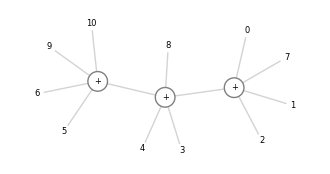

In [31]:
diag = DiagramBuilder()

c0, a0, b0, a1, b1, a2, b2 = diag.add_inputs(bits(7))
s1, c1 = full_adder @ diag[c0, a0, b0]
s2, c2 = full_adder @ diag[c1, a1, b1]
s3, c3 = full_adder @ diag[c2, a2, b2]
diag.add_outputs([s1, s2, s3, c3])

rc_adder_3 = diag.diagram()

draw_diagram(
    rc_adder_3,
    node_label={"box": binop_labels, "diagram": {full_adder: "+"}},
    figsize=(4, 2),
)


The static method `Diagram.from_recipe` can be used to create diagrams by wrapping a diagram building "recipe" like the ones used above. The result is that the decorated `my_full_adder` is a diagram, equal to the original `full_adder`.

In [32]:
from collections.abc import Sequence
from tensorsat.diagrams import Wire

@Diagram.from_recipe
def my_full_adder(diag: DiagramBuilder) -> None:
    a, b, c_in = diag.add_inputs(bits(3))
    (x1,) = xor_ @ diag[a, b]
    (x2,) = and_ @ diag[a, b]
    (x3,) = and_ @ diag[x1, c_in]
    (s,) = xor_ @ diag[x1, c_in]
    (c_out,) = or_ @ diag[x2, x3]
    diag.add_outputs([s, c_out])

assert my_full_adder == full_adder
print(f"{my_full_adder = }")

my_full_adder = <Diagram: 8 wires, 5 blocks, 5 ports, from recipe 'my_full_adder'>


The `Diagram.recipe` decorator can be used to wrap a parametric recipe into a diagram generating function.
For example, below we create a function which instantiates a ripple-carry adder circuit given the number `num_bits` of bits for the summands.

In [33]:
@Diagram.recipe
def rc_adder(diag: DiagramBuilder, num_bits: int) -> None:
    inputs = diag.add_inputs(bits(2*num_bits+1))
    outputs: list[Wire] = []
    c = inputs[0]
    for i in range(num_bits):
        a, b = inputs[2 * i + 1 : 2 * i + 3]
        s, c = full_adder @ diag[c, a, b]
        outputs.append(s)
    outputs.append(c)
    diag.add_outputs(outputs)

rc_adder

Diagram.recipe(__main__.rc_adder)

Recipes can be explicitly instantiated by calling them, passing the required parameter value(s).

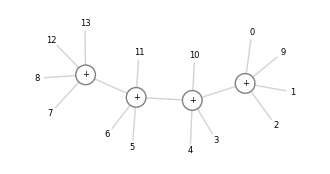

In [34]:
assert rc_adder(3) == rc_adder_3

draw_diagram(
    rc_adder(4),
    node_label={"box": binop_labels, "diagram": {full_adder: "+"}},
    figsize=(4, 2),
)

As an example of recipes being used in broader circuits, we implement the recipe for a multiply-add circuit.

In [35]:
from tensorsat.lib.bincirc import rc_adder, wallace_multiplier

@Diagram.recipe
def madd(diag: DiagramBuilder, num_bits: int) -> Sequence[Wire]:
    """Computes ``x+y*z`` for ``n``-bit numbers ``x``, ``y`` and ``z``."""
    if num_bits <= 0:
        raise ValueError("Number of bits must be positive.")
    x = diag.add_inputs(bits(num_bits))
    y = diag.add_inputs(bits(num_bits))
    z = diag.add_inputs(bits(num_bits))
    m = wallace_multiplier(num_bits) @ diag[*y, *z]
    carry0, = bit_0 @ diag[()]
    add_inputs: list[Wire] = [carry0]
    for x_bit, m_bit in zip(x, m):
        add_inputs.append(x_bit)
        add_inputs.append(m_bit)
    return rc_adder(num_bits) @ diag[*add_inputs]

madd

Diagram.recipe(__main__.madd)

Note that multiple wires connection two blocks are grouped together, with a number on the edge indicating the number of wires.

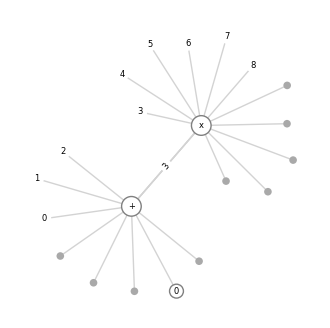

In [36]:
draw_diagram(
    madd(3),
    node_label={
        "box": binop_labels,
        "diagram": {
            wallace_multiplier: "x",
            rc_adder: "+",
        }
    },
    figsize=(4, 4),
)

Note that sub-diagrams are treated as if they were atomic boxes, even though they themselves have contents.
This can be seen above with the `rc_adder` sub-diagram (marked `+`) and the `wallace_multiplier` sub-diagram (marked `x`).
It exemplifies how the diagram data structure takes the form of a tree (or, more precisely, a directed acyclic graph): there is a top-level diagram, whose slots may be occupied by sub-diagrams, whose slots may in turn be occupied by sub-sub-diagrams, and so on.

The depth of such tree structures is captured by the `depth` property: in this example, the depth is 2, because both the `rc_adder` and `wallace_multiplier` recipes yield diagrams of depth 1 (they use `half_adder` and `full_adder` diagrams internally, which don't have sub-diagrams and hence have depth 0).

In [37]:
madd_3 = madd(3)
print(f"{madd_3 = }")
print(f"{madd_3.blocks[0] = }") # wallace_multiplier
print(f"{madd_3.blocks[1] = }") # bit_0
print(f"{madd_3.blocks[2] = }") # rc_adder


madd_3 = <Diagram: 22 wires, 3 blocks, depth 2, 9 ports, from recipe 'madd'>
madd_3.blocks[0] = <Diagram: 39 wires, 21 blocks, depth 1, 14 ports, from recipe 'wallace_multiplier'>
madd_3.blocks[1] = <FinRel: 1 ports>
madd_3.blocks[2] = <Diagram: 13 wires, 3 blocks, depth 1, 11 ports, from recipe 'rc_adder'>


Below we show the nested (left) and flat (right) version of three diagrams:

- a 3-bit `rc_adder`
- a 3-bit `wallace_multiplier`
- a 3-bit `madd` 

We use `draw_diagram.s` to quickly draw multiple diagrams in a given grid.

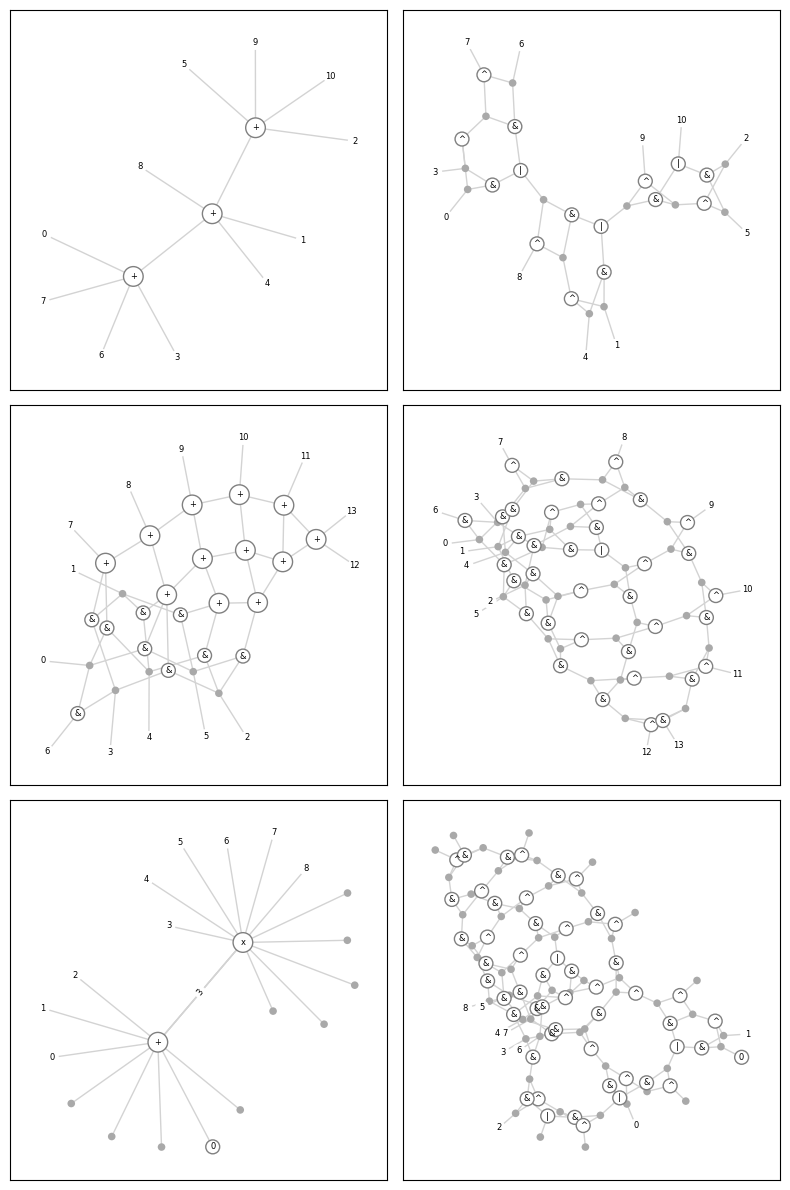

In [38]:
draw_diagram.s(
    madd_3.blocks[2],
    madd_3.blocks[2].flatten(),
    madd_3.blocks[0],
    madd_3.blocks[0].flatten(),
    madd_3,
    madd_3.flatten(),
    node_label={
        "box": binop_labels,
        "diagram": {
            wallace_multiplier: "x",
            rc_adder: "+",
            full_adder: "+",
            half_adder: "+",
        }
    },
    subplots=(3, 2),
    figsize=(8, 12)
)


## Contraction

Diagram contraction logic is implemented by concrete subclasses of the abstract base class `Contraction`.

In [39]:
from tensorsat.contractions import Contraction

Contractions are always performed relative to a given box class, which must implement the elementary contraction methods `spider`, `rewire` and `contract2`; this can be checked by looking at the `can_be_contracted` class method:

In [40]:
box_class = FinRel
box_class.can_be_contracted()

True

Contractions are also defined on a wiring, rather than a diagram. The reason why a wiring is used is that a contraction doesn't need to know about the specific boxes plugged into the diagram's slots, just their shape.

Individual concrete subclasses of `Contraction` provide different ways to build contractions.
The `SimpleContraction` class, for example, creates contractions from:

- a boxclass, e.g. `FinRel`
- a wiring
- a contraction path, e.g. as returned by [`opt_einsum.contract_path`](https://optimized-einsum.readthedocs.io/en/stable/autosummary/opt_einsum.contract_path.html).

A utility constructor `SimpleContraction.from_opt_einsum` is available which first uses [`opt_einsum.contract_path`](https://optimized-einsum.readthedocs.io/en/stable/autosummary/opt_einsum.contract_path.html) internally to find a good contraction path, and then construct the `SimpleContraction` instance from it.

In [41]:
from tensorsat.contractions.simple import SimpleContraction
diagram = full_adder
contraction = SimpleContraction.using_opt_einsum(FinRel, diagram.wiring)
contraction

<SimpleContraction>

The `contract` method of `Contraction` instances is used to contract a given diagram.
For example, below we use contraction to verify that our implementation of `full_adder` is correct.

In [42]:
box = contraction.contract(diagram)
display(sorted(box.to_set()))
for a, b, c_in, s, c_out in box.to_set():
    assert a+b+c_in == s+2*c_out

[(0, 0, 0, 0, 0),
 (0, 0, 1, 1, 0),
 (0, 1, 0, 1, 0),
 (0, 1, 1, 0, 1),
 (1, 0, 0, 1, 0),
 (1, 0, 1, 0, 1),
 (1, 1, 0, 0, 1),
 (1, 1, 1, 1, 1)]

Each utility constructor has an associated immediate contraction method, which creates a contraction with the utility constructor and then immediately uses it to contract the given diagram.

In [43]:
assert box == SimpleContraction.contract_using_opt_einsum(FinRel, diagram)

As another example, we look at diagram contraction for satisfiability.
We start with a small, randomly generated 3-SAT instance.

In [44]:
cnf = CNFInstance.random(3, 3, 6, rng=3)
cnf

<CNFInstance: 3 vars, 6 clauses, k=3>

We generate a diagram corresponding to the CNF formula, using balanced binary trees of `or_` operators to perform the disjunction of each CNF clause, and contracting the output of the disjunction with the `1` binary value to force the clause to be satisfied.

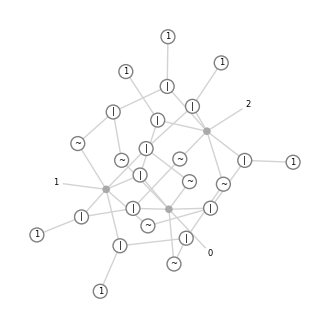

In [45]:
draw_diagram(
    cnf.diagram(mode="bintree"),
    node_label={"box": binop_labels},
    figsize=(4, 4),
)

We can use the `input` method of a CNF to generate a diagram corresponding to a given assignment of values to the variables.
We use `"0"` and `"1"` to specify a value, or `"?"` to leave the value undefined.

In [46]:
cnf.inputs("01?")

<Diagram: 3 wires, 3 blocks, 3 ports>

We can verify that the diagram above corresponds to the subset of 3-bit assignments where the first bit is set to 0, the second bit is set to 1, and the third bit has no set value.

In [47]:
SimpleContraction.contract_using_opt_einsum(FinRel, cnf.inputs("01?")).to_set()

frozenset({(0, 1, 0), (0, 1, 1)})

The relation is just the product of the three individual bit relations:

In [48]:
assert SimpleContraction.contract_using_opt_einsum(FinRel, cnf.inputs("01?")) == FinRel.prod(
    [bit_0, bit_1, bit_unk]
)

We apply the CNF diagram to the inputs diagram, and flatten, to obtain a test for the assignment.
Writing $\varphi$ for the formula, the test below correspond to the following statement:

$$
\exists \, b_2 \in \lbrace 0, 1 \rbrace \text{ s.t. } \varphi(0, 1, b_2)
$$


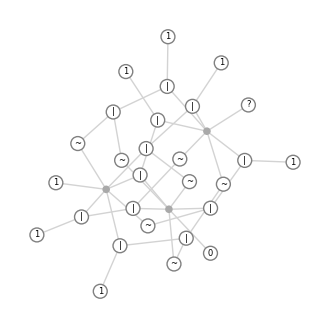

In [49]:
test_01u = (cnf.inputs("01?") >> cnf.diagram(mode="bintree")).flatten()
draw_diagram(
    test_01u,
    node_label={"box": binop_labels},
    figsize=(4, 4),
)


The `>>` operator provides a quick way to compose diagrams in sequence, without the need for an explicit builder.

In [50]:
builder = DiagramBuilder()
wires = cnf.inputs("01?") @ builder # same as @ builder[()], i.e. no inputs.
out_wires = cnf.diagram(mode="bintree") @ builder[wires]
builder.add_outputs(out_wires)
assert builder.diagram() == cnf.inputs("01?") >> cnf.diagram(mode="bintree")

The result of the contraction is a scalar box (one with no ports), and we can convert it to a Boolean to check for satisfiability.

In [51]:
result = SimpleContraction.contract_using_opt_einsum(FinRel, test_01u)
print(f"{result = }")
print(f"{bool(result) = }")

result = <FinRel: 0 ports>
bool(result) = True


As a more sophisticated example, we write a simple algorithm using tensor contraction to find a satisfying assignment for a SAT formula in $O(2n)$ contractions, where $n$ is the number of variables.

The wiring of CNF diagram is independent of the assignments of values to its variables, and the `contraction_wiring` method of the `CNFInstance` class computes this common wiring.

In [52]:
cnf_contraction = SimpleContraction.using_opt_einsum(FinRel, cnf.contraction_wiring(mode="bintree"))
cnf_contraction

<SimpleContraction>

In [53]:
from typing import Literal
cnf_diag = cnf.diagram()
n = cnf.num_vars
assert n >= 1 # we want to use the empty string as a flag for unsat
assignment: str = ""
for i in range(n):
    found: Literal["0", "1"] | None = None
    for b in "01":
        candidate = assignment[:i]+b+"?"*(n-i-1)
        print(f"Testing candidate {candidate}...", end="")
        test_diag = (cnf.inputs(candidate)>>cnf_diag).flatten()
        if cnf_contraction.contract(test_diag):
            found = b
            print("sat")
            break
        else:
            print("unsat")
    if found:
        assignment += found
    else:
        assignment = ""
        break
if assignment:
    print(f"Found satisfying assignment: {assignment}")
else:
    print("No satisfying assignment exists.")


Testing candidate 0??...sat
Testing candidate 00?...unsat
Testing candidate 01?...sat
Testing candidate 010...

unsat
Testing candidate 011...sat
Found satisfying assignment: 011
